In [38]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [39]:
import os
import shutil
import random

source_dir = r"c:\Users\sarva\Downloads\Minor-project\PlantVillage"
target_dir = r"c:\Users\sarva\Downloads\Minor-project\PlantVillage_split"
splits = ['Training', 'Validation', 'Testing']
split_ratio = [0.7, 0.15, 0.15]  # 70% train, 15% val, 15% test

if os.path.exists(target_dir):
    print("Split folders already exist. Skipping split.")
else:
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        images = os.listdir(class_path)
        random.shuffle(images)
        n_total = len(images)
        n_train = int(n_total * split_ratio[0])
        n_val = int(n_total * split_ratio[1])
        n_test = n_total - n_train - n_val
        split_counts = [n_train, n_val, n_test]
        start = 0
        for split, count in zip(splits, split_counts):
            split_dir = os.path.join(target_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img in images[start:start+count]:
                shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, img))
            start += count
    print("Dataset split completed.")

Split folders already exist. Skipping split.


In [40]:

# Update these variables in the next cell where you set train_dir, val_dir, test_dir:
train_dir = r"c:\Users\sarva\Downloads\Minor-project\PlantVillage_split\Training"
val_dir = r"c:\Users\sarva\Downloads\Minor-project\PlantVillage_split\Validation"
test_dir = r"c:\Users\sarva\Downloads\Minor-project\PlantVillage_split\Testing"

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 2077 files belonging to 3 classes.
Found 445 files belonging to 3 classes.
Found 446 files belonging to 3 classes.
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [41]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 2 1 2 0 0 0 2 1 1 0 2 2 0 0 1 0 0 2 0 0 0 1 1 1 1 2 2 2 2 1]


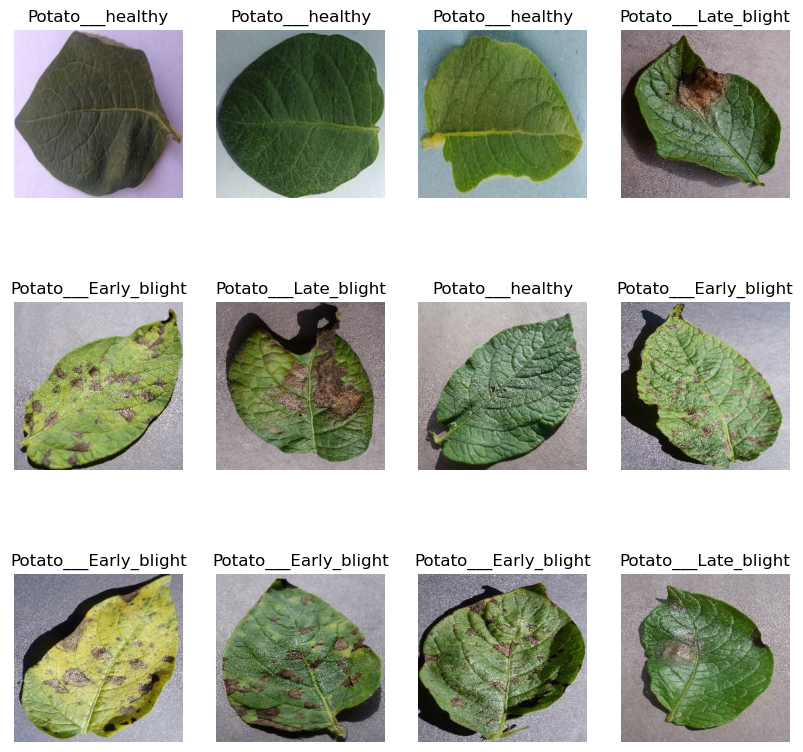

In [42]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4,  i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [47]:
from tensorflow.keras.layers import Resizing, Rescaling

resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255),
])


In [48]:
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])


In [49]:
# --- Update input_shape and model.build ---
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [50]:
# --- Update model.build call ---
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [51]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,075 (793.26 KB)

 Trainable params: 203,075 (793.26 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [53]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 57s 851ms/step - accuracy: 0.4540 - loss: 0.9684 - val_accuracy: 0.6809 - val_loss: 0.7123
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 56s 859ms/step - accuracy: 0.7456 - loss: 0.5422 - val_accuracy: 0.7708 - val_loss: 0.4976
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 54s 833ms/step - accuracy: 0.8259 - loss: 0.4002 - val_accuracy: 0.8449 - val_loss: 0.3456
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 56s 852ms/step - accuracy: 0.8946 - loss: 0.2533 - val_accuracy: 0.9438 - val_loss: 0.1569
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 55s 847ms/step - accuracy: 0.9553 - loss: 0.1261 - val_accuracy: 0.9258 - val_loss: 0.2009
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 55s 850ms/step - accuracy: 0.9549 - loss: 0.1128 - val_accuracy: 0.9798 - val_loss: 0.0753
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 55s 854ms/step - accuracy: 0.9635 - loss: 0.0941 - val_accuracy: 0.9573 - val_loss: 0.1274
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 54s 832ms/step - accuracy: 0.9671 - loss: 0.0898 - val_accu

In [54]:
scores = model.evaluate(test_ds, verbose=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9954 - loss: 0.0133


first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
predicted label: Potato___Early_blight


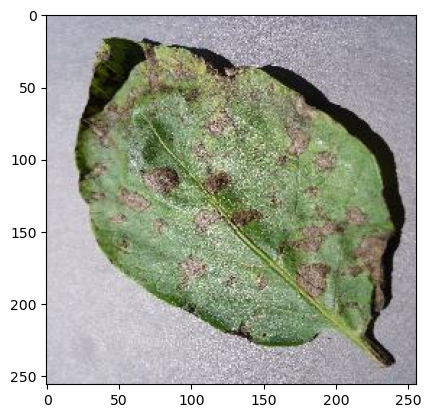

In [55]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[31].numpy().astype('uint8')
    first_label = labels_batch[31].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[10])])

In [56]:
scores

[0.0235795509070158, 0.9910314083099365]

In [57]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 65}

In [58]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

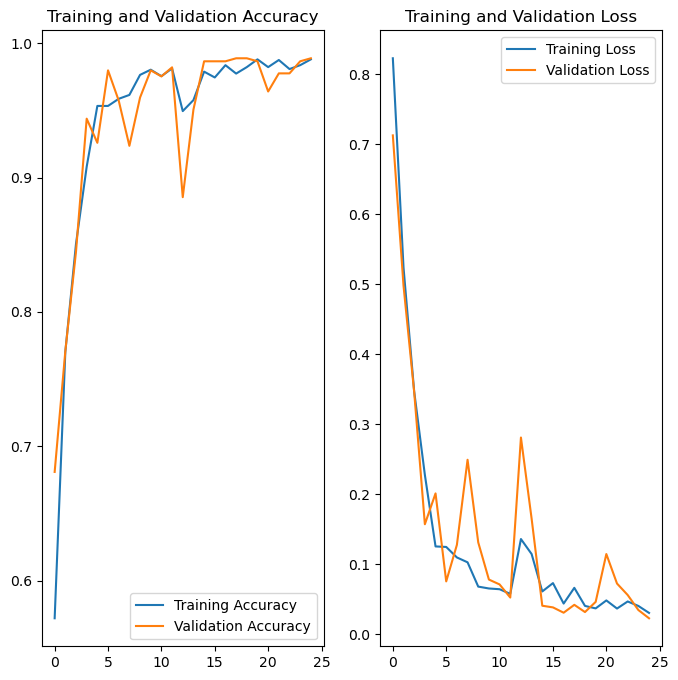

In [60]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


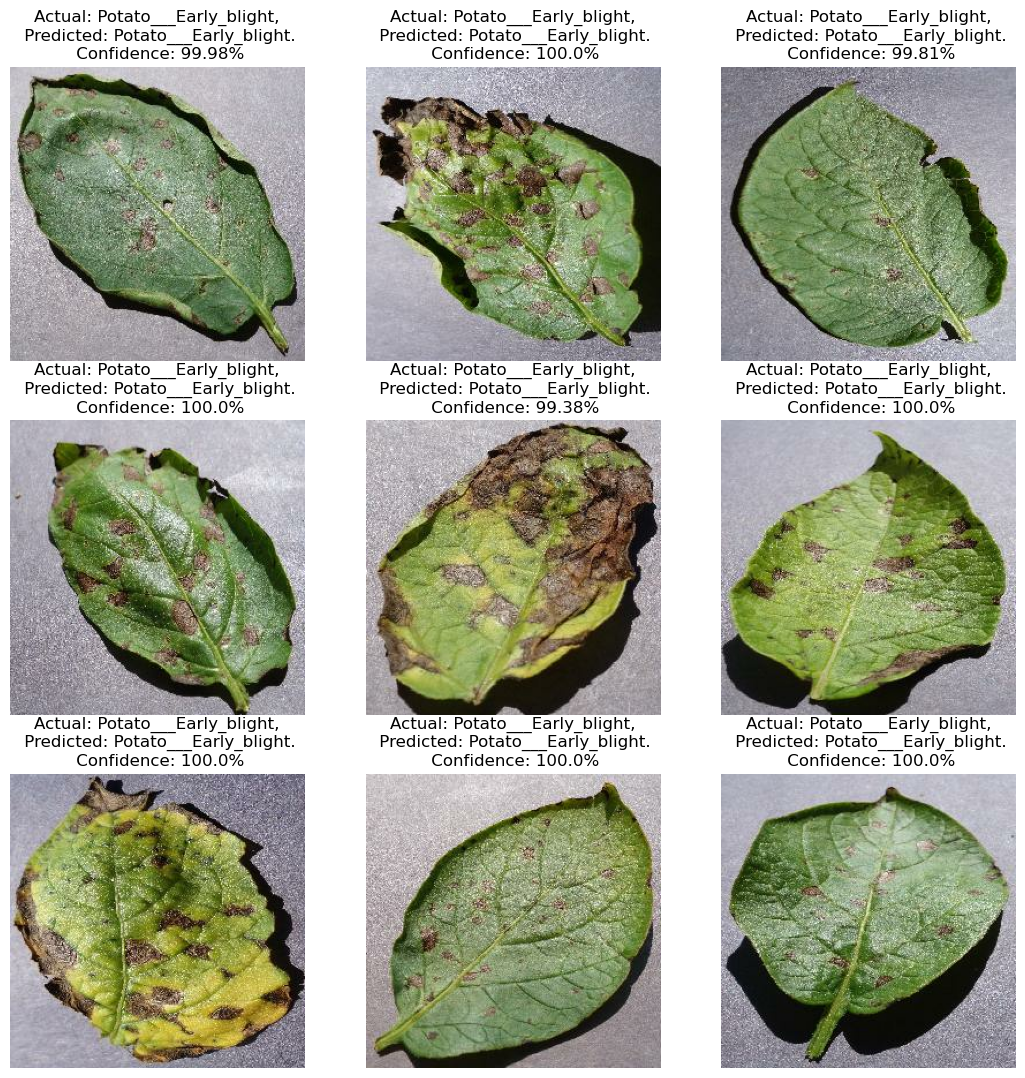

In [62]:
plt.figure(figsize=(13, 13))
for images, labels in test_ds.take(1):
    batch_size = images.shape[0]
    for i in range(min(9, batch_size)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [63]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    preds = model.predict(images_batch)
    y_true.extend(labels_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Precision: 0.9911347448447686
Recall: 0.9910313901345291
F1 Score: 0.9910298996153019
Confusion Matrix:
 [[150   0   0]
 [  1 149   0]
 [  0   3 143]]
Classification Report:
                        precision    recall  f1-score   support

Potato___Early_blight       0.99      1.00      1.00       150
 Potato___Late_blight       0.98      0.99      0.99       150
     Potato___healthy       1.00      0.98      0.99       146

             accuracy    

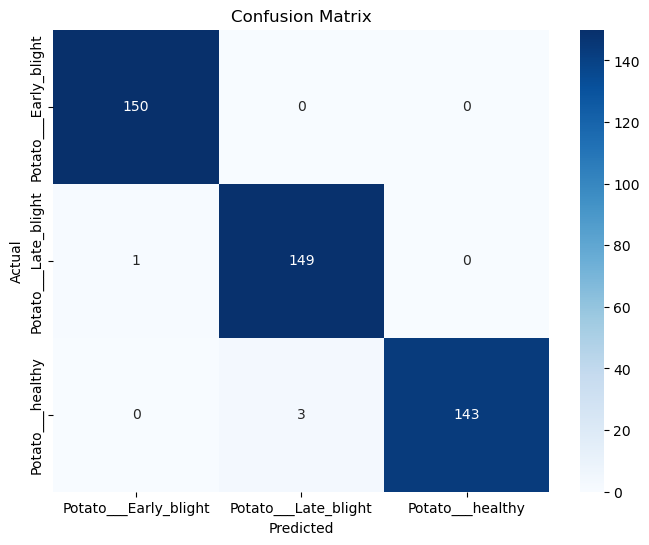

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

import os
save_dir = r"c:\Users\sarva\Downloads\Minor-project\saved_models"
os.makedirs(save_dir, exist_ok=True)
model_version = max([int(i) for i in os.listdir(save_dir) if i.isdigit()] + [0]) + 1
model_path = os.path.join(save_dir, str(model_version))
model.export(model_path)  

INFO:tensorflow:Assets written to: c:\Users\sarva\Downloads\Minor-project\saved_models\1\assets


INFO:tensorflow:Assets written to: c:\Users\sarva\Downloads\Minor-project\saved_models\1\assets


Saved artifact at 'c:\Users\sarva\Downloads\Minor-project\saved_models\1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_48')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1467615792208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1467615792784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1467615793744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1467615795856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1467615795472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1467615794896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1467615796432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1467615796048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1467615796816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1467615796624: TensorSpec(shape=(), dtype=tf.resource, name=No